In [1]:
output_path = './outputs/graphs/'
results_path = 'outputs/imagenet64_random_label_and_noise/'

In [2]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import graph_code.graphing_utils as plotting

In [3]:
colwidth = 4.22716535
pagewidth = 8.7598425

In [4]:
results_list = []

for file in [
    f for f in os.listdir(results_path) if f.endswith("json")
]:
    with open(results_path + file) as f:
        results_temp = json.load(f)
    results_list.append(results_temp)


In [5]:
results = {}

for results_dict in results_list:
    
    for dataset in results_dict:
        if dataset not in results:
            results[dataset] = {}

        for run in results_dict[dataset]:
            if run not in results[dataset]:
                results[dataset][run] = {}

            for depression in results_dict[dataset][run]:

                results[dataset][run][depression] = [
                    dict(epoch=int(epoch), **metrics) 
                    for epoch, metrics in results_dict[dataset][run][depression].items() 
                    if epoch != 'corrupt_sources'
                ]

In [6]:
results_df = []

for dataset in results:
    for run in results[dataset]:
        for depression in results[dataset][run]:
            results_df.append(
                pd.json_normalize(
                    results[dataset][run][depression]
                )
                .assign(
                    dataset=dataset,
                    run=run,
                    depression=depression
                )
                .assign(epoch=lambda x: x['epoch']+1)
            )

results_df = pd.concat(results_df)
results_df = (
    results_df
    .replace({"depression": {"true": True, "false": False}})
    .astype(
        {
            "run": "int64",
            "depression": "bool",
        }
    )
)

In [7]:
results_df = results_df.melt(
    id_vars=['dataset', 'run', 'depression', 'epoch'],
    var_name='metric',
    value_name='value'
)

In [8]:
results_final_df = (
    results_df
    .loc[lambda df: df.metric == 'test_top5acc']
    .groupby(["depression", "run"])
    [['value']]
    .max()
    .assign(value = lambda x: x['value']*100)
    .reset_index()
    .groupby(["depression"])
    ['value']
    .agg(['mean', 'std'])
    .assign(
        mean_std = lambda x: 
            np.round(x['mean'], 2).astype(str) 
            + " ± "
            + np.round(x['std'], 2).astype(str),
    )
    ['mean_std']
    .to_frame()
    .reset_index()
    .rename(columns={"depression": "LAP", "mean_std": "Top-5 Accuracy"})
    .replace(
        {
            "LAP": {
                False: "Standard",
                True: "LAP (Ours)"
            }
        }
    )
    .assign(**{"Noise Type": "Input and Label Noise"})
    .pivot(
        index="Noise Type",
        columns="LAP",
        values="Top-5 Accuracy"
    )
    .reset_index()
    [[
        'Noise Type',  'Standard', 'LAP (Ours)',
    ]]
)

results_final_df

LAP,Noise Type,Standard,LAP (Ours)
0,Input and Label Noise,68.05 ± 0.26,70.61 ± 0.26


In [9]:
print(
    results_final_df.to_latex(index=False)
)

\begin{tabular}{lll}
\toprule
Noise Type & Standard & LAP (Ours) \\
\midrule
Input and Label Noise & 68.05 ± 0.26 & 70.61 ± 0.26 \\
\bottomrule
\end{tabular}



And the average accuracy over the last 10 epochs:

In [10]:
results_df_average_accuracy_last_10_epochs = (
    results_df
    .loc[lambda df: df.metric == 'test_top5acc']
    .loc[lambda df: df["epoch"] > df["epoch"].max() - 10]
    .assign(value = lambda x: x['value']*100)
    .groupby(["depression", "metric"])
    ["value"]
    .agg(['mean', 'std'])
    .assign(
        mean_std = lambda x: 
            np.round(x['mean'], 2).astype(str) 
            + " ± "
            + np.round(x['std'], 2).astype(str),
    )
    ['mean_std']
    .to_frame()
    .reset_index()
    .rename(columns={"depression": "LAP", "mean_std": "Top-5 Accuracy"})
    .replace(
        {
            "LAP": {
                False: "Standard",
                True: "LAP (Ours)"
            }
        }
    )
    .assign(**{"Noise Type": "Input and Label Noise"})
    .pivot(
        index="Noise Type",
        columns="LAP",
        values="Top-5 Accuracy"
    )
    .reset_index()
    [[
        'Noise Type',  'Standard', 'LAP (Ours)',
    ]]
)
results_df_average_accuracy_last_10_epochs

LAP,Noise Type,Standard,LAP (Ours)
0,Input and Label Noise,42.96 ± 0.64,66.26 ± 0.21


In [11]:
print(
    results_df_average_accuracy_last_10_epochs.to_latex(index=False)
)

\begin{tabular}{lll}
\toprule
Noise Type & Standard & LAP (Ours) \\
\midrule
Input and Label Noise & 42.96 ± 0.64 & 66.26 ± 0.21 \\
\bottomrule
\end{tabular}



## Training loss and test accuracy

In [18]:
results_df_plot = (
    results_df
    .replace({
        "depression": {
            False: "Standard",
            True: "LAP (Ours)"
        },
        "metric": {
            "test_top5acc": "Test Top-5 Accuracy",
            "test_loss": "Test Loss",
            "train_top5acc": "Train Top-5 Accuracy",
            "train_loss": "Train Loss",
            "val_top5acc": "Validation Top-5 Accuracy"
        }
    })
    # .assign(
    #     epoch = lambda x: x['epoch']
    # )
)
results_df_plot

,dataset,run,depression,epoch,metric,value
0,imagenet64,1,LAP (Ours),1,Train Loss,4.482276
1,imagenet64,1,LAP (Ours),2,Train Loss,2.425986
2,imagenet64,1,LAP (Ours),3,Train Loss,2.119808
3,imagenet64,1,LAP (Ours),4,Train Loss,1.932778
4,imagenet64,1,LAP (Ours),5,Train Loss,1.800751
...,...,...,...,...,...,...
8095,imagenet64,5,Standard,86,Test Top-5 Accuracy,0.433280
8096,imagenet64,5,Standard,87,Test Top-5 Accuracy,0.430640
8097,imagenet64,5,Standard,88,Test Top-5 Accuracy,0.425700
8098,imagenet64,5,Standard,89,Test Top-5 Accuracy,0.428420


In [38]:
epoch_of_max = (
    results_df_plot
    .query("depression == 'LAP (Ours)'")
    .query("metric == 'Test Top-5 Accuracy'")
    .pipe(
        lambda df: df.iloc[df['value'].argmax()]
    )
    ['epoch']
)

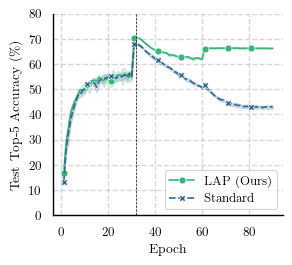

In [67]:
with plotting.paper_theme():
    plt.close()

    fig, ax = plt.subplots(figsize=((2/3)*colwidth, 0.6*colwidth))

    ax = sns.lineplot(
        data=results_df_plot.query("metric == 'Test Top-5 Accuracy'"),
        x='epoch',
        y='value',
        hue='depression',
        style='depression',
        hue_order=["LAP (Ours)", "Standard"],
        palette=sns.color_palette(plotting.palette, 2)[::-1],
        ax=ax,
        markers=['o', 'X'],
        markersize=5,
        markeredgewidth=0.5,
        errorbar='sd',
        markevery=10,
    )

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Test Top-5 Accuracy (\%)")

    ax.set_yticks(
        ax.get_yticks()
    )
    ax.set_yticklabels(
        (ax.get_yticks()*100).astype(int)
    )


    sns.move_legend(ax, "lower right", title="")

    ax.axvline(
        epoch_of_max,
        color='black',
        linestyle='--',
        linewidth=0.5
    )
    
    fig.subplots_adjust(top=0.97, bottom=0.175, left=0.175, right=0.99)

    plotting.save_fig(
        fig, output_path + "imagenet64_random_label_and_noise_top5acc"
    )

    plt.show()

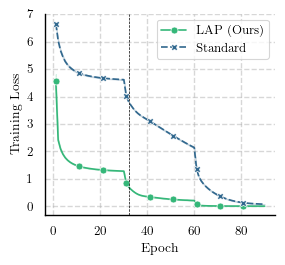

In [68]:
with plotting.paper_theme():
    plt.close()

    fig, ax = plt.subplots(figsize=((2/3)*colwidth, 0.6*colwidth))

    ax = sns.lineplot(
        data=results_df_plot.query("metric == 'Train Loss'"),
        x='epoch',
        y='value',
        hue='depression',
        style='depression',
        hue_order=["LAP (Ours)", "Standard"],
        palette=sns.color_palette(plotting.palette, 2)[::-1],
        ax=ax,
        markers=['o', 'X'],
        markersize=5,
        markeredgewidth=0.5,
        errorbar='sd',
        markevery=10,
    )

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Training Loss")

    sns.move_legend(ax, "upper right", title="")

    ax.axvline(
        epoch_of_max,
        color='black',
        linestyle='--',
        linewidth=0.5
    )
    
    fig.subplots_adjust(top=0.97, bottom=0.175, left=0.175, right=0.99)

    plotting.save_fig(
        fig, output_path + "imagenet64_random_label_and_noise_train_loss"
    )

    plt.show()

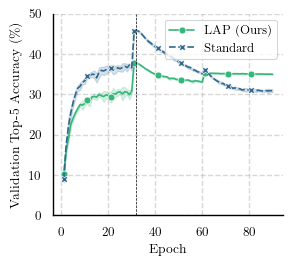

In [69]:
with plotting.paper_theme():
    plt.close()

    fig, ax = plt.subplots(figsize=((2/3)*colwidth, 0.6*colwidth))

    ax = sns.lineplot(
        data=results_df_plot.query(
            "metric == 'Validation Top-5 Accuracy'"
        ),
        x='epoch',
        y='value',
        hue='depression',
        style='depression',
        hue_order=["LAP (Ours)", "Standard"],
        palette=sns.color_palette(plotting.palette, 2)[::-1],
        ax=ax,
        markers=['o', 'X'],
        markersize=5,
        markeredgewidth=0.5,
        errorbar='sd',
        markevery=10,
    )


    ax.set_xlabel("Epoch")
    ax.set_ylabel("Validation Top-5 Accuracy (\%)")


    ax.set_yticks(
        ax.get_yticks()
    )
    ax.set_yticklabels(
        (ax.get_yticks()*100).astype(int)
    )


    sns.move_legend(ax, "upper right", title="")

    ax.axvline(
        epoch_of_max,
        color='black',
        linestyle='--',
        linewidth=0.5
    )
    
    fig.subplots_adjust(top=0.97, bottom=0.175, left=0.175, right=0.99)

    plotting.save_fig(
        fig, output_path + "imagenet64_random_label_and_noise_val_acc"
    )

    plt.show()